In [1]:
import matplotlib.pyplot as plt
import os
os.environ['THEANO_FLAGS'] = 'device=cuda0'
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
import pymc3 as pm
import numpy as np
import pandas as pd
import fault3d as f3
from matplotlib import ticker, cm
from pathlib import Path
import re
from theano.compile.ops import as_op
from geoist import gridder
from pymc3 import (
        NUTS,
        DensityDist,
        Dirichlet,
        Metropolis,
        MvNormal,
        Normal,
        Slice,
        find_MAP,
        sample,
    )
theano.config.floatX = "float32"

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 8201 on context None
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/theano/gpuarray/__init__.py", line 159, in init_dev
    pygpu.blas.gemm(0, tmp, tmp, 0, t

[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/examples'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/temp'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/data'


In [2]:
inp_file = "data/fault3d.inp"
log_file = "log.txt"

23.214298


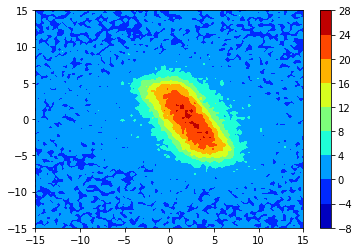

<Figure size 432x288 with 0 Axes>

In [3]:
nx = 90
ny = 90
narea = tuple([-15, 15, -15, 15])
nshape = tuple([nx, ny])
outfile = f3.fault3d.fault(inp_file, log_file, nx, ny)
xp, yp, zp = gridder.regular(narea, nshape, z=0)

xp = np.array(xp)
yp = np.array(yp)
data = np.array(outfile).flatten()
print(np.max(data))
from geoist.pfm import giutils
field = giutils.contaminate(np.array(data), 0.05, percent = True, seed = 2022)
data = field

v = {
        'x' : list(yp),
        'y' : list(xp),
        'data' : data,}

x = xp.reshape(nx, ny)
y = yp.reshape(nx, ny)
da = data.reshape(nx, ny)
plt.contourf(x, y, da, cmap=cm.jet)
plt.colorbar()
plt.show()
plt.savefig("df.png")
obs_data = np.concatenate((da[:, 30],da[:, 55],da[50,:]))

In [4]:
23.214298*0.05

1.1607149

In [5]:
save_data = pd.DataFrame(v)
save_data.to_csv("figure1b_data.csv")

In [6]:
%time
obs_data = np.concatenate((da[:, 30],da[:, 55],da[50,:]))
np.savetxt('obs_1113.txt', obs_data, delimiter="\n")

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.58 µs


In [7]:
def make_datafile(v, depth_bottom, dip, filename = 'f3d.dat'):
    with open(filename,'w') as f:
        f.write('1, 0\n')
        f.write('0.0, 0.0\n')
        f.write(str(v)+','+' 0.5,'+str(depth_bottom)+", 3.0")
        f.write(',6.0,L,')
        f.write(str(dip))
        f.write(',60,GL1,1.5,0.0\n')

In [8]:
@as_op(itypes=[tt.fscalar, tt.fscalar, tt.fscalar],otypes=[tt.fvector])
def get_gravity(density_inv, depth_bottom, dip):
    
    make_datafile(density_inv, depth_bottom, dip)
    outfile = f3.fault3d.fault("f3d.inp", log_file, nx, ny)
    data = np.array(outfile).flatten()
    da = data.reshape(nx, ny)
    predict_data = np.concatenate((da[:, 30],da[:, 55],da[50, :]))
    
    os.remove("f3d.dat")
    return predict_data

In [ ]:
%time
inp_file = "f3d.inp"
# 密度，顶深，底深，顶宽，走向延伸长度，倾向角度，走向角度，中心坐标X,中心坐标Y
# ref = [2.61, 0.5, 2.5, 2.0, 4.0, 150, 60, 4.0, 0]
m1 = pm.Model()
with m1:
    #密度在[-0.1, 2]之间均匀采样
    density_inv = pm.Uniform('Density', lower = 0.3, upper = 0.8)
#    length = pm.Uniform('Length', lower = 2, upper = 5) 
#    depth_topo = pm.Uniform("Depth_top", lower = 0, upper = 1.0)
    depth_bottom = pm.Uniform("Depth_bottom", lower = 1.5, upper = 4)
    dip = pm.Uniform("Dip", lower = 110, upper = 170)
    #dip1 = 180-dip
    sd  = pm.HalfNormal("sd", sigma = 2)

    gz_exp = get_gravity(density_inv, depth_bottom, dip)
    predict = pm.Deterministic("predict_data", gz_exp)   #Save the trace
    jobs = pm.Normal('obsj', mu= predict, sd = sd, observed= obs_data)
    
#    step1 = pm.NUTS(vars = [sd])
    step = pm.Slice()
    #对后验进行采样
    trace = pm.sample(draws = 10000, tune = 10000, chains = 2, cores=1, step = step, random_seed=202243)    #step = step, start = map_estimate       

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs


Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [sd]
>Slice: [Dip]
>Slice: [Depth_bottom]
>Slice: [Density]
Sampling chain 0, 0 divergences:  21%|██        | 4101/20000 [2:34:19<10:29:01,  2.37s/it]

In [21]:
summary = pm.summary(trace, hdi_prob=0.95)

/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Density'}>],
       [<AxesSubplot:title={'center':'Depth_bottom'}>,
        <AxesSubplot:title={'center':'Depth_bottom'}>],
       [<AxesSubplot:title={'center':'Dip'}>,
        <AxesSubplot:title={'center':'Dip'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'predict_data'}>,
        <AxesSubplot:title={'center':'predict_data'}>]], dtype=object)

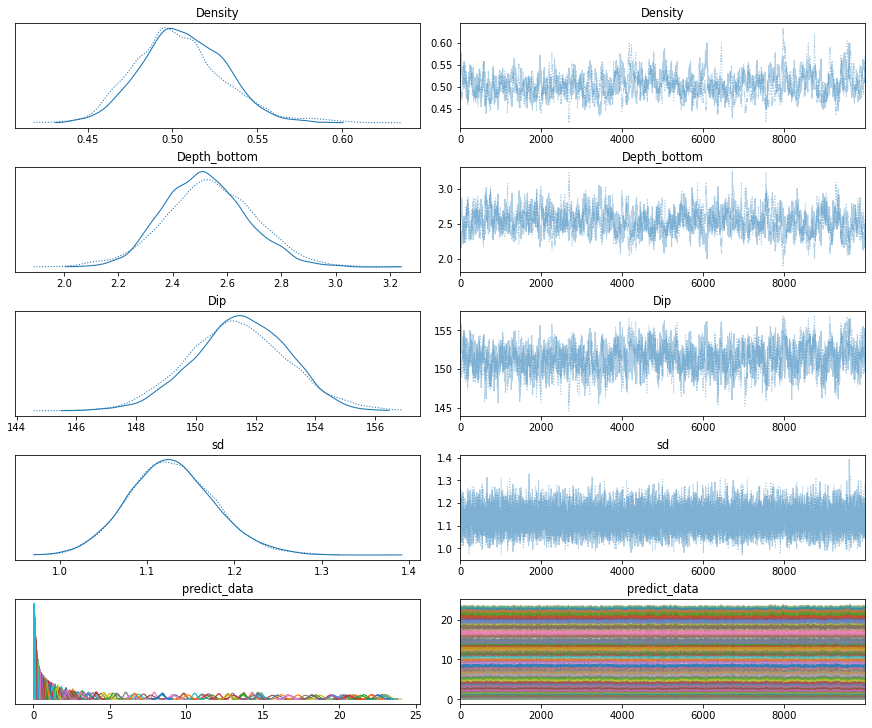

In [22]:
pm.traceplot(trace)

In [23]:
densitymean = np.array(summary['mean'])[0:7]
densitymean

array([  0.505,   2.53 , 151.446,   1.128,   0.425,   0.428,   0.432])

In [24]:
summary[0:6]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Density,0.505,0.026,0.456,0.556,0.002,0.001,302.0,299.0,312.0,473.0,1.01
Depth_bottom,2.530,0.163,2.221,2.859,0.009,0.006,344.0,344.0,341.0,520.0,1.01
Dip,151.446,1.649,148.258,154.709,0.079,0.056,434.0,432.0,431.0,701.0,1.00
sd,1.128,0.049,1.030,1.224,0.000,0.000,19057.0,18725.0,19463.0,15528.0,1.00
predict_data[0],0.425,0.032,0.364,0.490,0.001,0.001,1467.0,1467.0,1414.0,2785.0,1.00
predict_data[1],0.428,0.032,0.366,0.492,0.001,0.001,1440.0,1440.0,1388.0,2771.0,1.00


In [31]:
elements = ['Density', "Depth_bottom","Dip"]
data_re = pd.DataFrame({"Density": np.array(trace["Density"]),
                       "Depth_bottom": np.array(trace["Depth_bottom"]), "Dip": np.array(trace["Dip"])})
data_re.to_csv("trace_de_top_10.csv")

In [26]:
re = summary["mean"][4:]
np.savetxt('result_1113.txt',re,delimiter="\n")

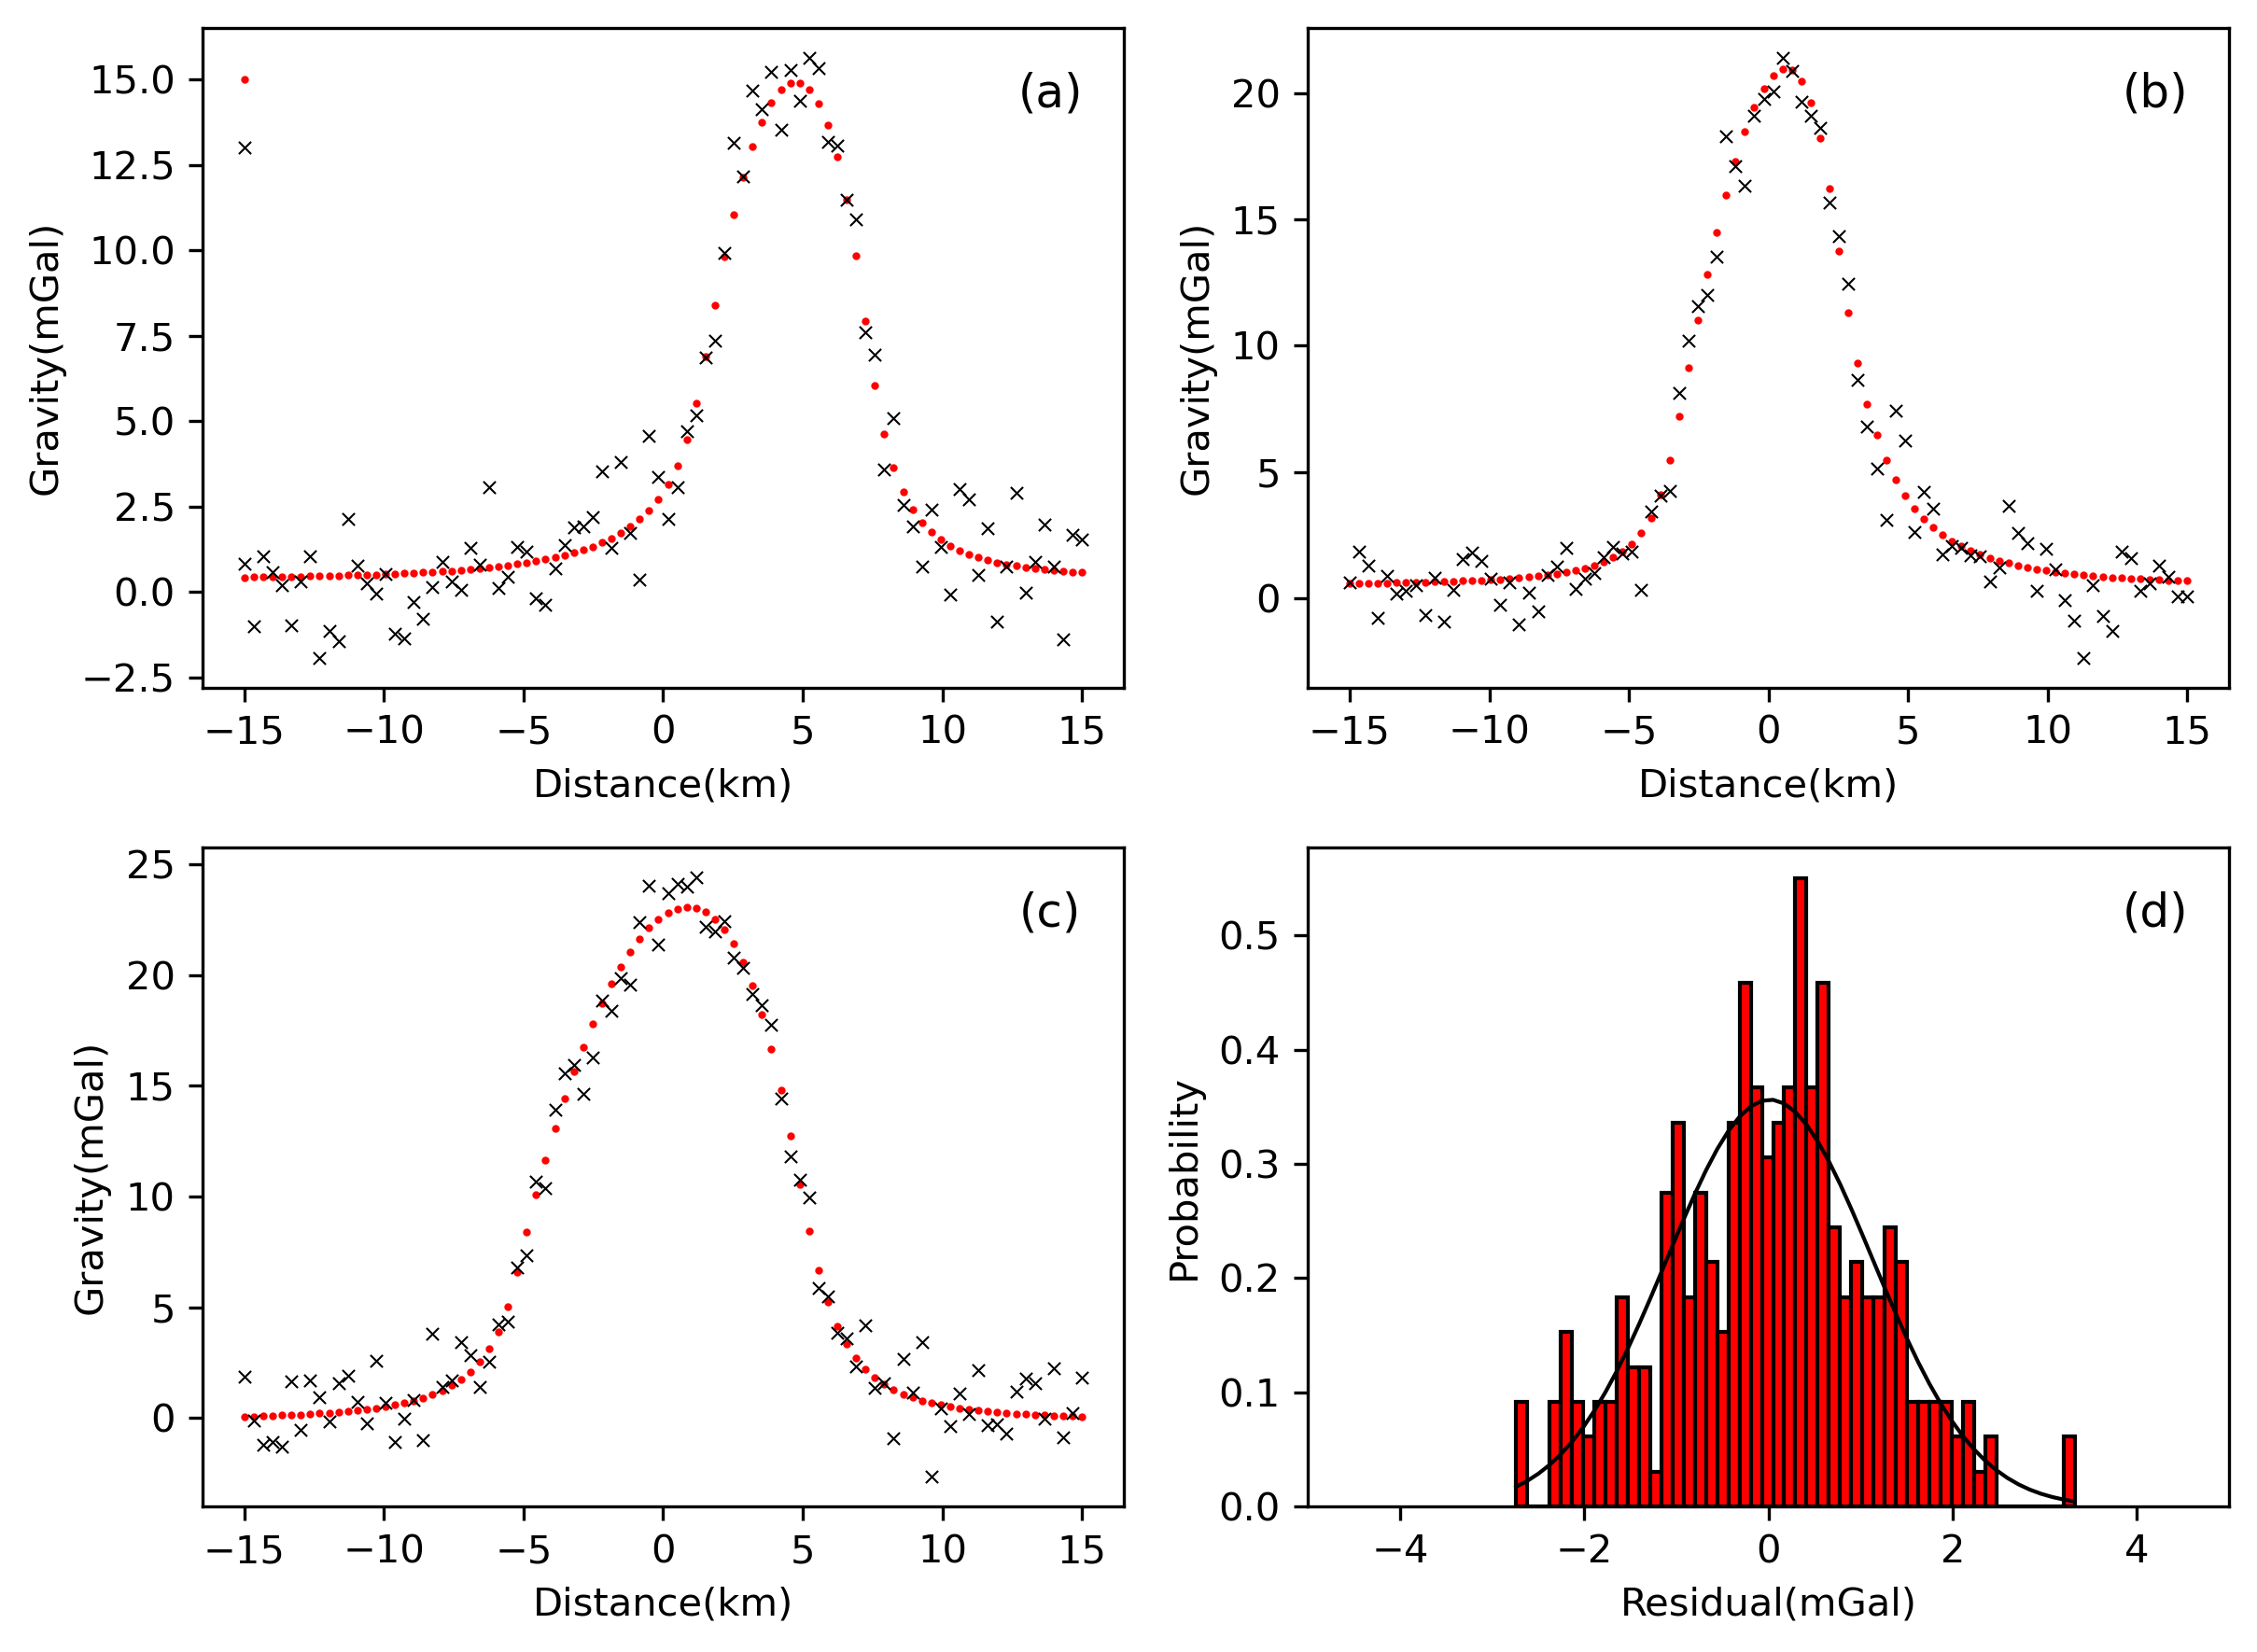

In [27]:
#re = trace["predict_data"][99]
xline = np.linspace(-15, 15, num=90, endpoint=True)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize =(8,6), dpi = 300)

axs = axs.flatten()
axs[0].scatter(xline, re[0:90], s = 1, color = "r")
axs[0].scatter(xline, obs_data[0:90], s = 10, color = 'k', marker = 'x', linewidth = 0.5)
axs[0].set_xlabel("Distance(km)")
axs[0].set_ylabel("Gravity(mGal)")
axs[0].scatter([-15], [15], s = 1, color = "r")
axs[0].scatter([-15], [13], s = 10, color = 'k', marker = 'x', linewidth = 0.5)
axs[0].text(0.92, 0.9, "(a)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[0].transAxes)
#axs[0].text( 0.1, 0.1, "(a)", transform = ax.transAxes)

axs[1].scatter(xline, re[90:180], s = 1, color = "r")
axs[1].scatter(xline, obs_data[90:180], s = 10, color = "k", marker = 'x', linewidth = 0.5)
axs[1].set_xlabel("Distance(km)")
axs[1].set_ylabel("Gravity(mGal)")
axs[1].text(0.92, 0.9, "(b)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[1].transAxes)

axs[2].scatter(xline, re[180:270], s = 1, color = "r")
axs[2].scatter(xline, obs_data[180:270], s = 10, color = "k", marker = 'x', linewidth = 0.5)
axs[2].set_xlabel("Distance(km)")
axs[2].set_ylabel("Gravity(mGal)")
axs[2].text(0.92, 0.9, "(c)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[2].transAxes)

# Histogram 
ress = np.array(re[0:270]-obs_data)
mu = np.mean(ress)
sigma = np.std(ress, ddof = 1 )

n, bins, patches = axs[3].hist(ress, 50, density=True, color = "red", edgecolor='black')
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axs[3].plot(bins, y, color = "black", linewidth = "1")
axs[3].set_xlabel("Residual(mGal)")
axs[3].set_ylabel("Probability")
axs[3].set_xlim(-5, 5)
axs[3].text(0.92, 0.9, "(d)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[3].transAxes)

fig.tight_layout()
plt.savefig("gravity_contrast_1.png",)
plt.savefig("gravity_contrast_1.pdf")
plt.savefig("gravity_contrast_1.eps")
plt.show()

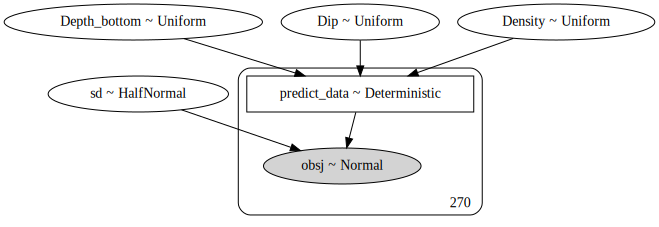

In [28]:
pm.model_to_graphviz(m1)

In [29]:
print(sigma)

1.1194023495609806


In [30]:
mu

0.014020916938336766

In [ ]:
1